In [58]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import *

# Description of PCA
---


**The principle**

We have input data matrix X of dimension $R^{m*p}$:
* each of the m rows is a sample
* each of the p columns is a feature

We look for a transformation W of dimension $R^{p*l}$ where l is typically lower than p:
* The new data will be $T = XW$ of dimension $R^{m*l}$
* The new features will be ordered by decreasing variance along the dimension

We can see this matrix W as a set of $l$ vectors $w_j$ of dimension $p$. Each feature for each sample $i$ is obtained by multiplying the sample $x_i$ with $w_j$. So basically: $T_{i,j} = x_i w_j$.


**How we proceed**

The variance along the axis k is by definition $\sum_{i=1}^m (t_{i,k} - \bar{t}_k)^2$ where:

* $i$ runs through all the samples
* $\bar{t}_k$ is the expected value of $t_{i,k}$ on all samples $i$

We can rework this expression (and considering that the data is centered in zero):

$\sum_{i=1}^m (t_{i,k})^2 = \sum_{i=1}^m (x_i w_k)^2 = ||X w_k||^2 = w_k^T X^T X w_k$.

This is the Rayleigh quotient, and to maximize it, we need to find the eigenvalues and eigenvectors for the matrix $X^T X$ and order them from the highest to the smallest eigenvalues.

We then pick the a sub-selection of $l < p$ eigenvectors of size $p$ to form the matrix $W$ for dimension $R^{p*l}$.


**Important notes**

* the covariance only find linear (not even affine) relationships (we will see example after)
* the data needs to be centered in zero for each dimension individually in order to work

# Simple example (workable by hand)
---

The notations here:

* X represents the data set $R^{m*p}$
* each of the $m$ row of X is a sample
* each of the $p$ column of X is a feature

In [53]:
# 3 samples, with clearly correlated features
X = np.array([
    [-1., 2.],
    [ 0., 0.],
    [ 1, -2.]])

print("Covariance matrix:")
cov = X.T @ X
print(cov)

# Example of eigenvector
# Just solve the 2 equations with two unknowns:
#   2x - 4y = a * x
#  -4x + 8y = a * y
# Which implies that: a * (y + 2 x) = 0
# Which implies that: y = - 2 x (or else null eigenvalue)
v = np.array([1, -2]) / np.sqrt(5)
print("* eigen vector:", v)
print("* eigen value:", (cov @ v) / v)

# We can use NUMPY to find the eigenvalues and eigen vectors
eigen_values, eigen_vectors = np.linalg.eig(cov)

# Just keep the highest
descending_indices = np.argsort(eigen_values)[::-1]
W = eigen_vectors[:,descending_indices[:1]]
print("\nTransformation:")
print(W)

# Use this to reduce the new data
print("\nNew data:")
T = X @ W
print(T)

Covariance matrix:
[[ 2. -4.]
 [-4.  8.]]
* eigen vector: [ 0.4472136  -0.89442719]
* eigen value: [10. 10.]

Transformation:
[[ 0.4472136 ]
 [-0.89442719]]

New data:
[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]


We can use scikit-learn to do this automatically for us (with a better algorithm).

In [61]:
X = np.array([
    [-1., 2.],
    [ 0., 0.],
    [ 1, -2.]])

pca = PCA(n_components=1)
pca.fit_transform(X)

array([[-2.23606798],
       [ 0.        ],
       [ 2.23606798]])

# Limits of PCA
---

The naive PCA is computationally intensive (due to the eigen value decomposition and the matrix multiplication to get the covariance matrix).

PCA is limited to find linear relationships, due to the definition of covariance between two variables: $E[(X_i - \bar{X_i})(X_j - \bar{X_j})]$ and more generally the fact that we work with linear functions (eigen vectors, orthogonal rotation matrix).

**Example:**

* In polar coordinates $\rho e^{i\theta}$, the data has low variance for $\rho$, but high variance for $\theta$
* If we had to keep an axis, it would be the axis for $\theta$, but in the cartesian coordinates, PCA cannot do this

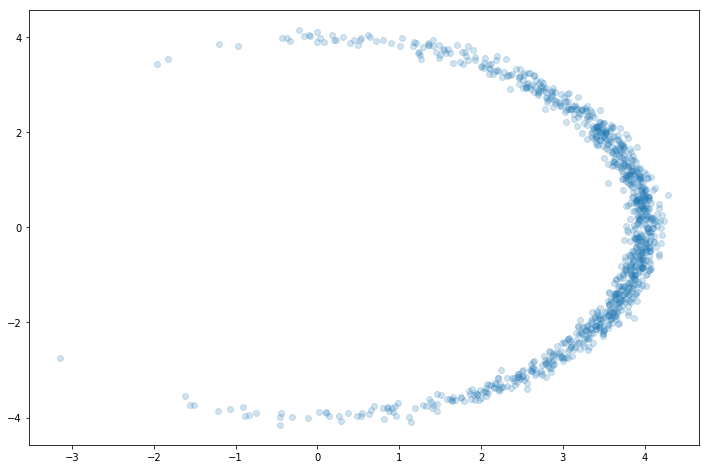

In [87]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.show()

We can lift this limitations by first transforming our data into another vector space that makes the relations between variable appear linear. This is typically done by projecting in higher dimensions.

Here we illustrate what it does with a transformation from cartesian coordinates back to polar coordinates (so that it stays in 2D and is drawable), but in the general case:

1. we do not know which transformation to apply
2. we do not care about the reverse projection

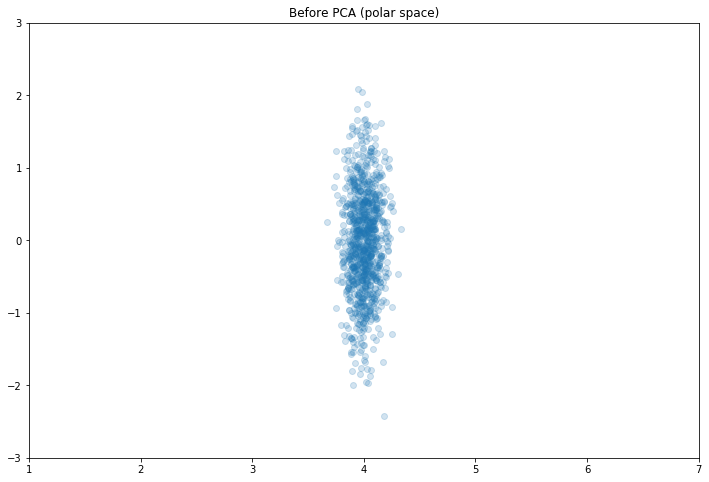

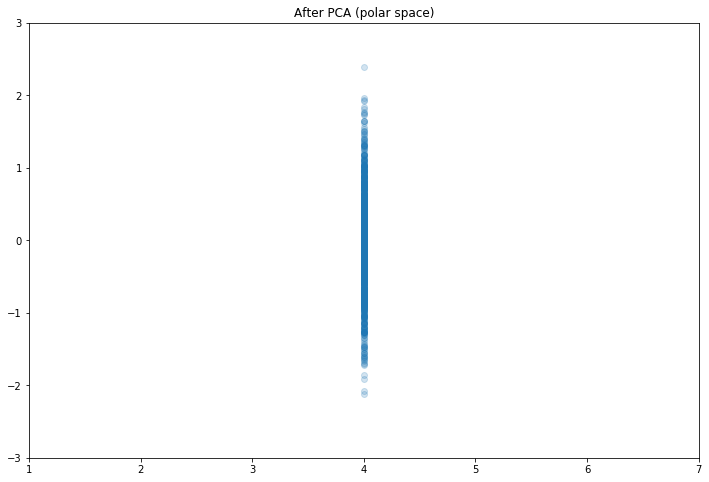

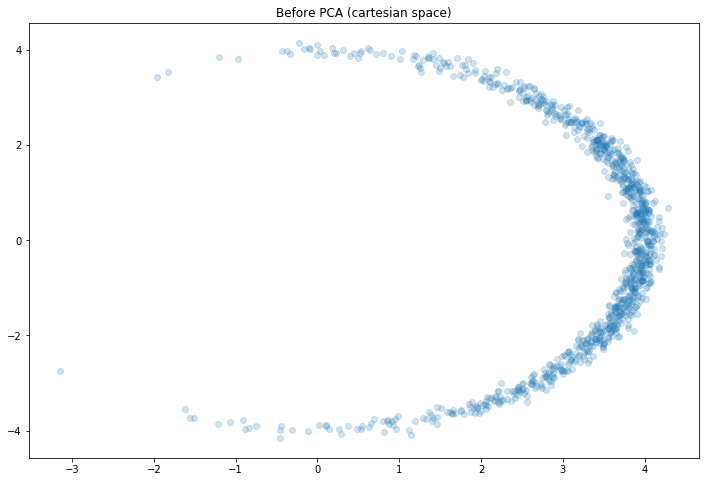

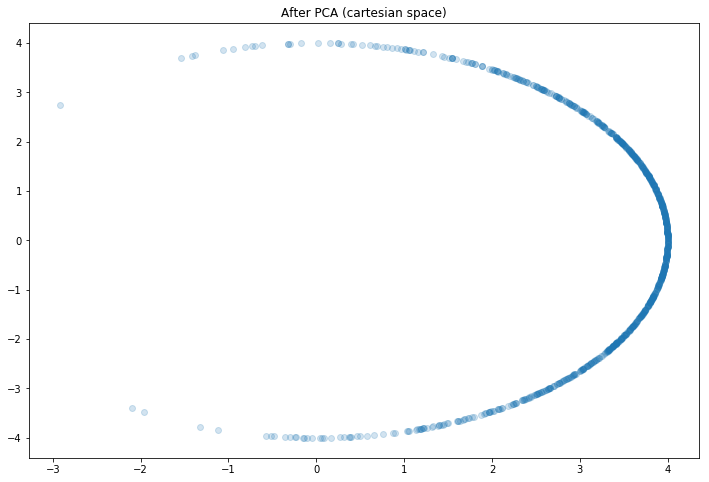

In [108]:
# The projection in different space
def project(cluster):
    norms = np.sqrt(cluster[:,0] ** 2 + cluster[:,1] ** 2)
    theta = np.arctan2(cluster[:,1], cluster[:,0])
    return np.concatenate([np.expand_dims(norms, -1), np.expand_dims(theta, -1)], axis=1)
    

# Show the result of the projection
T = project(X)
plt.figure(figsize=(12, 8))
plt.scatter(T[:,0], T[:,1], alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("Before PCA (polar space)")
plt.show()


# Remove the means in the projected space
feature_means = np.mean(T, axis=0)
T = T - feature_means


# Extract the principal components
pca = PCA(n_components=1)
T2 = pca.fit_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2, alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("After PCA (polar space)")
plt.show()


# Show the result on the main space
X2 = transform(np.concatenate([np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2], axis=1))

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

**Important notes:**
* the graphical illustrations are in 2D here in order to explain visually the effect of PCA, but in reality, one of the dimension has been completely removed (and we just have 1D)
* the alignment along the directions of the axis here is not necessary: PCA will find rotations if necessary

# Kernel PCA
---

The idea of transforming in a higher dimensional space is useful, but leads to more involved computations, since the number of dimension is higher. We can make use of the kernel trick to limit the amount of computations.

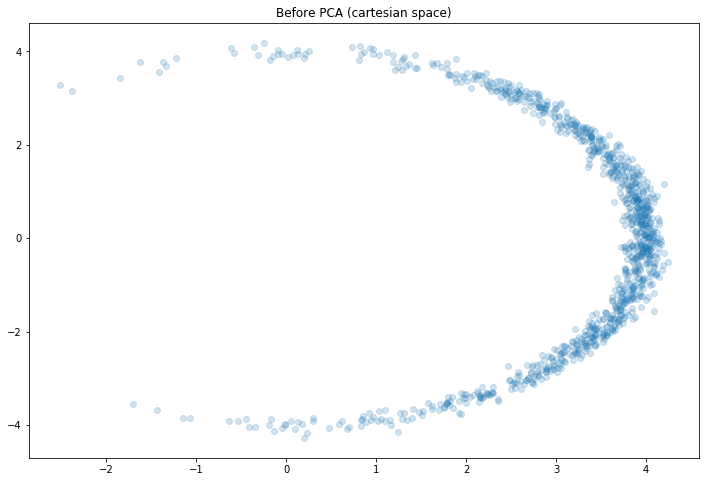

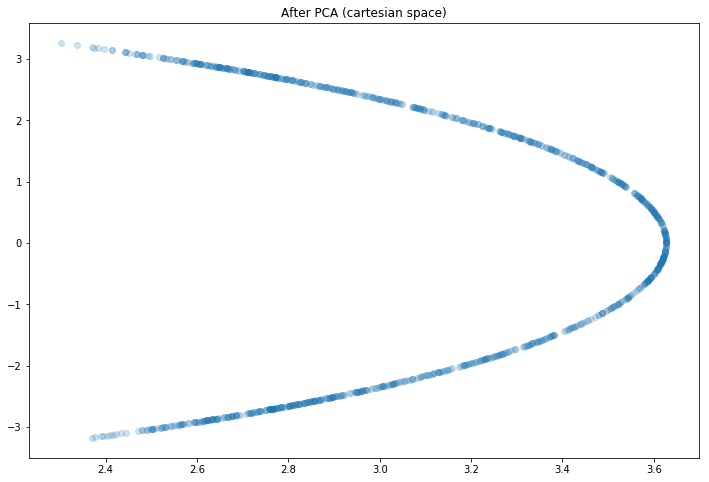

In [129]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

pca = KernelPCA(kernel='poly', n_components=1, fit_inverse_transform=True)
T = pca.fit_transform(X)

X2 = pca.inverse_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

Now, there is a degradation that we can witness when we reconstruct the data.

However, PCA is often used as a first dimensionality reduction technique in order to solve a specific task. Ultimately, the quality of the transformation / dimensionnality reduction can only be assessed by checking whether or not the task we are interested in is still solvable with the same accuracy after the transformation.

# Auto-encoders
---